In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
seed = 50
from sklearn.model_selection import KFold

# 设置全局字体属性
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['font.serif'] = 'Times New Roman'  
plt.rcParams['font.size'] = 16  

### SGD class and SGD_regularization class

In [2]:
class SGD:

    def __init__(self, learning_rate=0.001, max_iters=100, epsilon=1e-8, record_history=True, batch_size=50):
        self.learning_rate = learning_rate  # Learning rate
        self.max_iters = max_iters  # Maximum number of iterations
        self.record_history = record_history  # Whether to record the history of weights
        self.epsilon = epsilon  # Convergence precision
        self.batch_size = batch_size  # Size of mini-batch
        if record_history:
            self.w_history = []  # List to store the history of weights for visualization
            self.grad_history = [] # List to store gradient
            self.mse_history = [] # List to store

    def run(self, gradient_fn, x, y, w):
        t = 1
        while t < self.max_iters:
            indices = np.random.choice(len(x), self.batch_size, replace=False)  # Randomly select indices for a mini-batch
            x_batch = x[indices, :]
            y_batch = y[indices, :]
            grad, mse = gradient_fn(x_batch, y_batch, w)  # Calculate the gradient using the mini-batch
            self.mse_history.append(mse)
            self.grad_history.append(grad)
            # print(f"grad{t} = {np.linalg.norm(grad, ord=2)}")
            w = w - self.learning_rate * grad.T  # Weight update step
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

class SGD_regularization:

    def __init__(self, type, learning_rate=0.001, max_iters=100, epsilon=1e-8, record_history=True, batch_size=50,
                 lambda_=0.01):
        
        self.learning_rate = learning_rate  # Learning rate
        self.max_iters = max_iters  # Maximum number of iterations
        self.record_history = record_history  # Whether to record the history of weights
        self.epsilon = epsilon  # Convergence precision
        self.batch_size = batch_size  # Size of mini-batch
        self.lambda_ = lambda_  # Regularization parameter
        if record_history:
            self.w_history = []  # List to store the history of weights for visualization
            self.grad_history = [] # List to store gradient
        self.type = type

    def run(self, gradient_fn, x, y, w):  # Add regularization parameter lambda_
        t = 1
        while t < self.max_iters:
            indices = np.random.choice(len(x), self.batch_size, replace=False)
            x_batch = x[indices, :]
            y_batch = y[indices, :]
            grad, mse = gradient_fn(x_batch, y_batch, w)
            self.grad_history.append(grad)

            # Impact of regularization term on the gradient
            if w.ndim == 1:
                w = w[None,:]
                
            reg_term = None
            if self.type == "L1":
                reg_term = self.lambda_ * np.sign(w[:, :-1]) # Gradient of the L1 regularization term
            elif self.type == "L2":
                reg_term = self.lambda_ * w[:, :-1]  # Gradient of the L2 regularization term
            
            reg_term = np.hstack((reg_term, np.zeros((reg_term.shape[0], 1))))
            reg_term = reg_term.reshape(len(grad),1)
            grad += reg_term  # Add the regularization term to the gradient

            # print(f"grad{t} = {np.linalg.norm(grad, ord=2)}")
            w = w - self.learning_rate * grad.T
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w


### Linear Regression class with SGD and Linear Regression class with numerical method

In [3]:
# function for MSE
calculate_mse = lambda true, predicted: ((true - predicted) ** 2).mean()

class LinearRegression_SGD:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias  # Whether to add bias term (intercept) to the model
            
    def fit(self, x, y, optimizer):
        x = np.atleast_2d(x)  
        if y.ndim == 1:
            y = y[:, None]
            
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.full(len(x), 1)])
        N, D = x.shape
        
        def gradient(x, y, w):
            yh = (x @ w.T)
            yh = np.array(yh).reshape(-1, 1)
            grad = np.dot(x.T, yh - y) / len(x)
            mse = calculate_mse(y, yh)
            return grad, mse

        w0 = np.zeros(D)  # Initialize weights to zeros
        self.w = optimizer.run(gradient, x, y, w0)  # Run the optimizer to find optimal weights
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x, np.full(len(x), 1)])
        yh = x @ (self.w).T  # Make predictions using learned weights
        return yh
    
   
    
class LinearRegression_numerical:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias  # Whether to add bias term (intercept) to the model
            
    def fit(self, x, y):
        x = np.atleast_2d(x)  
        if y.ndim == 1:
            y = y[:, None]
            
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])  # Add bias term to the input data
        N, D = x.shape
        
        self.w = (np.linalg.lstsq(x, y)[0]).T
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x, np.ones(len(x))])  # Add bias term to the input data
        yh = x @ (self.w).T  # Make predictions using learned weights
        return yh

# Helper function for MSE and 5-cross validation

In [4]:
# function for MSE
calculate_mse = lambda true, predicted: ((true - predicted) ** 2).mean()

def perform_5_fold_cross_validation(model_instance, X_train, y_train, optimizer=None, seed=seed):
    if seed is not None:
        np.random.seed(seed)

    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    mse_scores = []

    for fold_number, (train_index, val_index) in enumerate(kf.split(X_train), start=1):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Train the model
        if optimizer != None:
            model_instance.fit(X_train_fold, y_train_fold, optimizer)
        else:
            model_instance.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        prediction = model_instance.predict(X_val_fold)

        # Calculate and store MSE
        mse = calculate_mse(y_val_fold, prediction)
        mse_scores.append(mse)

        # Print the MSE for the current fold
        print(f"Fold {fold_number}: MSE = {mse}")

    # Calculate the average MSE over 5-fold cross-validation
    average_mse = np.mean(mse_scores)
    return average_mse



# Load boston dataset

In [5]:
# Read the CSV file containing data
data = np.genfromtxt('boston_clean.csv', delimiter=',', skip_header=1)

# Extract the first column as the target array y
y = data[:, 0]

# Extract all the remaining columns as the feature matrix X

X = data[:, 1:]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Ensure y_test has the correct shape
y_test = y_test[:, None]

# Print the shapes of various data
print("Shape of y:", y.shape)
print("Shape of X:", X.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_test:", X_test.shape)


Shape of y: (506,)
Shape of X: (506, 12)
Shape of y_train: (404,)
Shape of X_train: (404, 12)
Shape of y_test: (102, 1)
Shape of X_test: (102, 12)


# Test the MSE and 5 fold cross validation of the model

Fold 1: MSE = 138.03402412204304
Fold 2: MSE = 123.20238028929923
Fold 3: MSE = 220.23485872450593
Fold 4: MSE = 165.90699686557846
Fold 5: MSE = 133.84463369885742
MSE = 184.4057
5-fold Cross-Validation Avg. MSE = 156.2446


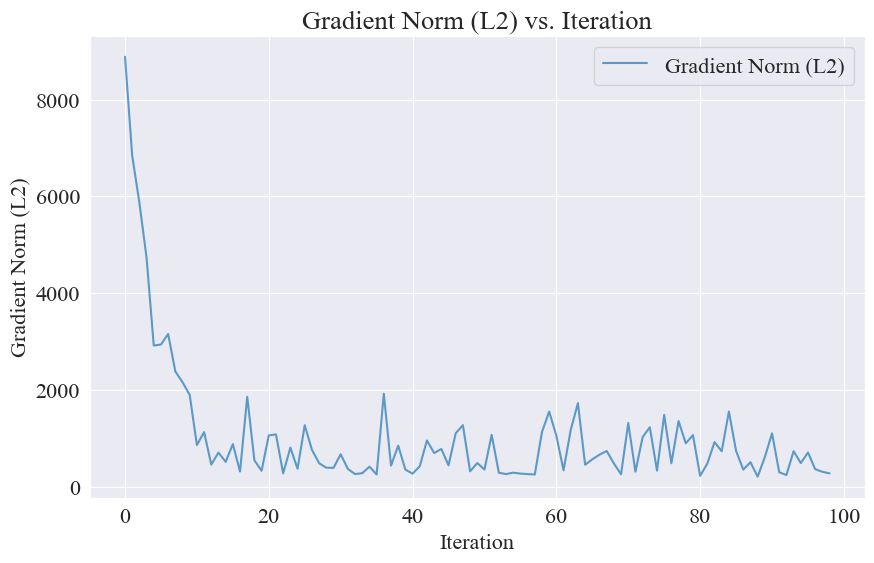

In [29]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Define the optimizer 
optimizer = SGD(learning_rate=1/1.1e+6, max_iters=100, record_history=True, batch_size=64)

# Create a Linear Regression model using SGD
model_LR_SGD = LinearRegression_SGD()

# Train the model on the training data
model_LR_SGD.fit(X_train, y_train, optimizer)

# Get a separate copy of the gradient history for plotting
grad_history = list(optimizer.grad_history)  # Make a copy

# Make predictions on the test data
prediction = model_LR_SGD.predict(X_test)

# Calculate the Mean Squared Error (MSE) for the predictions
mse = calculate_mse(y_test, prediction)

# Evaluate the model's performance using 5-fold Cross-Validation
average_mse = perform_5_fold_cross_validation(model_LR_SGD, X_train, y_train, optimizer)

# Print the calculated MSE and average Cross-Validation MSE
print(f"MSE = {mse:.4f}")
print(f"5-fold Cross-Validation Avg. MSE = {average_mse:.4f}")

# Plot the gradient changes over iterations (limit to the first 500 iterations)
plt.figure(figsize=(10, 6))
plt.plot(range(len(grad_history)), [np.linalg.norm(grad, ord=2) for grad in grad_history], label='Gradient Norm (L2)', alpha=0.7)

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm (L2)')
plt.title('Gradient Norm (L2) vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()

Fold 1: MSE = 247.10087345004237
Fold 2: MSE = 223.58459836465317
Fold 3: MSE = 172.58338506139788
Fold 4: MSE = 79.86736985989288
Fold 5: MSE = 212.17300132158576
MSE = 156.9086
5-fold Cross-Validation Avg. MSE = 187.0618


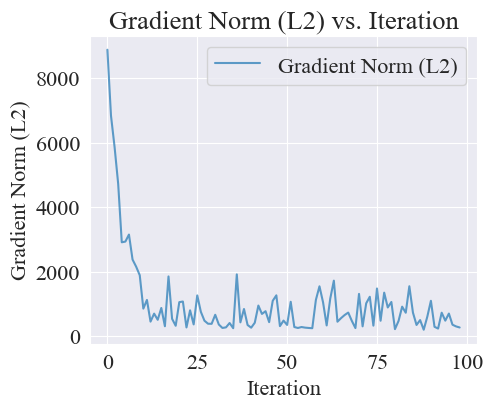

In [30]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Define the optimizer 
optimizer = SGD(learning_rate=1/1.1e+6, max_iters=100, record_history=True, batch_size=64)

# Create a Linear Regression model using SGD
model_LR_SGD = LinearRegression_SGD()

# Train the model on the training data
model_LR_SGD.fit(X_train, y_train, optimizer)

# Get a separate copy of the gradient history for plotting
grad_history = list(optimizer.grad_history)  # Make a copy

# Make predictions on the test data
prediction = model_LR_SGD.predict(X_train)

# Calculate the Mean Squared Error (MSE) for the predictions
mse = calculate_mse(y_train, prediction)

# Evaluate the model's performance using 5-fold Cross-Validation
average_mse = perform_5_fold_cross_validation(model_LR_SGD, X_test, y_test, optimizer)

# Print the calculated MSE and average Cross-Validation MSE
print(f"MSE = {mse:.4f}")
print(f"5-fold Cross-Validation Avg. MSE = {average_mse:.4f}")

# Plot the gradient changes over iterations (limit to the first 500 iterations)
plt.figure(figsize=(5, 4))
plt.plot(range(len(grad_history)), [np.linalg.norm(grad, ord=2) for grad in grad_history], label='Gradient Norm (L2)', alpha=0.7)

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm (L2)')
plt.title('Gradient Norm (L2) vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()

# Test the Model Performance with different size of training set

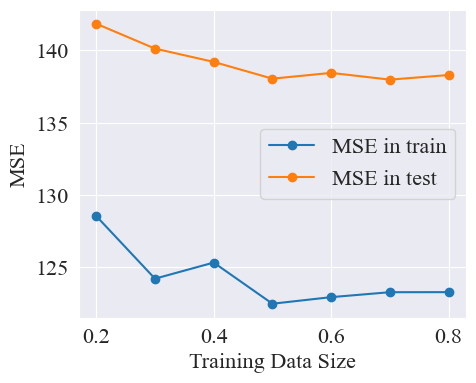

In [31]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Define the specific training data sizes, increasing X_train and y_train, and decreasing X_test and y_test
training_sizes = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

# Lists to store average MSE values for train and test
train_mse_values = []
test_mse_values = []

batch_size = 128

for size in training_sizes:
    # Calculate the number of samples for the current size
    num_samples_train = int(size * len(X_train))
    num_samples_test = int((1 - size) * len(X_test))
    
    # Repeat the process multiple times (e.g., 10 times) for robustness
    num_repeats = 10
    train_mse_sum = 0
    test_mse_sum = 0
    
    optimizer = SGD(learning_rate=1/1.1e+6, max_iters=1000, record_history=True, batch_size=int(batch_size * size))
    
    for _ in range(num_repeats):
        # Randomly sample a subset of the training data
        random_indices_train = np.random.choice(len(X_train), num_samples_train, replace=False)
        X_subset_train = X_train[random_indices_train]
        y_subset_train = y_train[random_indices_train]
        
        # Randomly sample a subset of the test data
        random_indices_test = np.random.choice(len(X_test), num_samples_test, replace=False)
        X_subset_test = X_test[random_indices_test]
        y_subset_test = y_test[random_indices_test]
        
        # Train the model on the subset
        model_LR_SGD.fit(X_subset_train, y_subset_train, optimizer)
        
        # Predict on the entire training and test datasets
        train_prediction = model_LR_SGD.predict(X_train)
        test_prediction = model_LR_SGD.predict(X_test)
        
        # Calculate MSE for both train and test
        train_mse = calculate_mse(y_train, train_prediction)
        test_mse = calculate_mse(y_test, test_prediction)
        
        train_mse_sum += train_mse
        test_mse_sum += test_mse
    
    # Calculate the average MSE for train and test
    avg_train_mse = train_mse_sum / num_repeats
    avg_test_mse = test_mse_sum / num_repeats
    
    train_mse_values.append(avg_train_mse)
    test_mse_values.append(avg_test_mse)

# Plot the curves for train and test MSE with a limited y-axis range
plt.figure(figsize=(5,4))
plt.plot(training_sizes, train_mse_values, marker='o', label='MSE in train')
plt.plot(training_sizes, test_mse_values, marker='o', label='MSE in test')
plt.xlabel('Training Data Size')
plt.ylabel('MSE')
# plt.title('MSE vs. Training Data Size')
plt.legend()
# plt.ylim(0, 1000)  # Set the y-axis range as needed
plt.grid(True)
plt.show()

# Test the Model Performance with different batch size

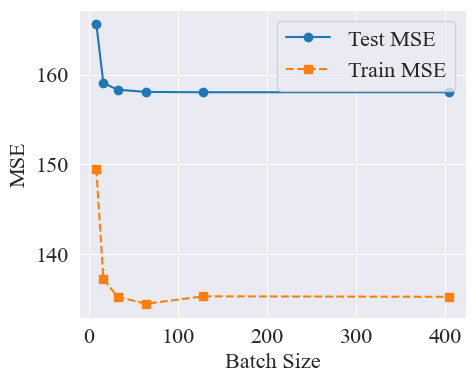

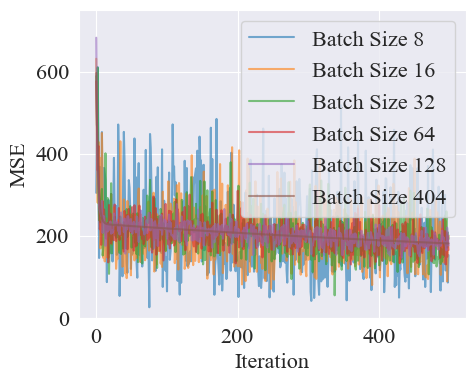

In [33]:
# Set a fixed random seed for reproducibility
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(seed)

# List of batch sizes to iterate over
batch_sizes = [8, 16, 32, 64, 128, 404]

# Lists to store MSE values and MSE histories for each batch size
mse_values_test = []
mse_values_train = []
mse_histories = []

for batch_size in batch_sizes:
    # Create a new SGD instance with the current batch size
    optimizer = SGD(learning_rate=1/1.1e+6, max_iters=500, record_history=True, batch_size=int(batch_size))

    # Train the model on the training data
    model_LR_SGD.fit(X_train, y_train, optimizer)

    # Make predictions on the test set and calculate the MSE for the predictions
    prediction_test = model_LR_SGD.predict(X_test)
    mse_test = calculate_mse(y_test, prediction_test)
    mse_values_test.append(mse_test)
    
    # Make predictions on the training set and calculate the MSE for the predictions
    prediction_train = model_LR_SGD.predict(X_train)
    mse_train = calculate_mse(y_train, prediction_train)
    mse_values_train.append(mse_train)

    # Assuming optimizer has an attribute mse_history which records the MSE at each iteration
    mse_histories.append(optimizer.mse_history)

# Plot the MSE values for different batch sizes
plt.figure(figsize=(5, 4))
plt.plot(batch_sizes, mse_values_test, marker='o', label='Test MSE')
plt.plot(batch_sizes, mse_values_train, marker='s', linestyle='dashed', label='Train MSE')
plt.xlabel('Batch Size')
plt.ylabel('MSE')
# plt.title('final MSE vs. Batch Size for Test and Train Data')
plt.legend()
plt.grid(True)
plt.show()

# Plot the MSE histories for different batch sizes
plt.figure(figsize=(5, 4))
for i, batch_size in enumerate(batch_sizes):
    plt.plot(range(len(mse_histories[i])), mse_histories[i], label=f'Batch Size {batch_size}', alpha=0.6)

plt.xlabel('Iteration')
plt.ylabel('MSE')
# plt.title('MSE vs. Iteration for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.ylim(0, max([max(history) for history in mse_histories]) * 1.1)
plt.show()


# Test the Model Performance with different learning rates

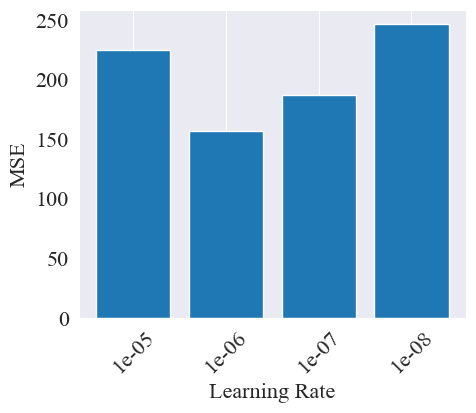

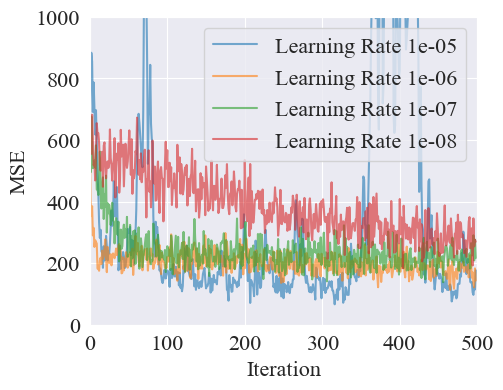

In [34]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# List of learning rates to iterate over
learning_rates = [1/1e+5, 1/1e+6, 1/1e+7, 1/1e+8]

# Lists to store MSE values and MSE histories for each learning rate
mse_values_lr = []
mse_histories_lr = []

# Iterate over different learning rates
for learning_rate in learning_rates:
    # Create a new SGD instance with the current learning rate
    optimizer = SGD(learning_rate=learning_rate, max_iters=500, record_history=True, batch_size=64)

    # Create a new Linear Regression model using SGD
    model_LR_SGD_lr = LinearRegression_SGD()

    # Train the model on the training data
    model_LR_SGD_lr.fit(X_train, y_train, optimizer)

    # Make predictions on the test set
    prediction = model_LR_SGD_lr.predict(X_test)

    # Calculate the Mean Squared Error (MSE) for the predictions
    mse = calculate_mse(y_test, prediction)
    mse_values_lr.append(mse)
    
    # Assuming optimizer has an attribute mse_history which records the MSE at each iteration
    mse_histories_lr.append(optimizer.mse_history) 

# Plot the MSE values for different learning rates as a bar chart
plt.figure(figsize=(5, 4))
plt.bar([str(lr) for lr in learning_rates], mse_values_lr)
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
# plt.title('MSE vs. Learning Rate')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

# Plot the MSE histories for different learning rates
plt.figure(figsize=(5, 4))
for i, learning_rate in enumerate(learning_rates):
    plt.plot(range(len(mse_histories_lr[i])), mse_histories_lr[i], label=f'Learning Rate {learning_rate}', alpha=0.6)

plt.xlabel('Iteration')
plt.ylabel('MSE')
# plt.title('MSE vs. Iteration for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.xlim(0,500)
# plt.ylim(0, max([max(history) for history in mse_histories_lr]) * 1.1)  # Adjusted the limit to accommodate the MSE values
plt.ylim(0,1000)  # Adjusted the limit to accommodate the MSE values
plt.show()


# Test the MSE and 5 fold cross validation of the model with regularization

Fold 1: MSE = 137.4193196743234
Fold 2: MSE = 122.66996213836636
Fold 3: MSE = 219.25928279569507
Fold 4: MSE = 165.2089681975488
Fold 5: MSE = 133.18154760807226
MSE = 183.6375
5-fold Cross-Validation Avg. MSE = 155.5478


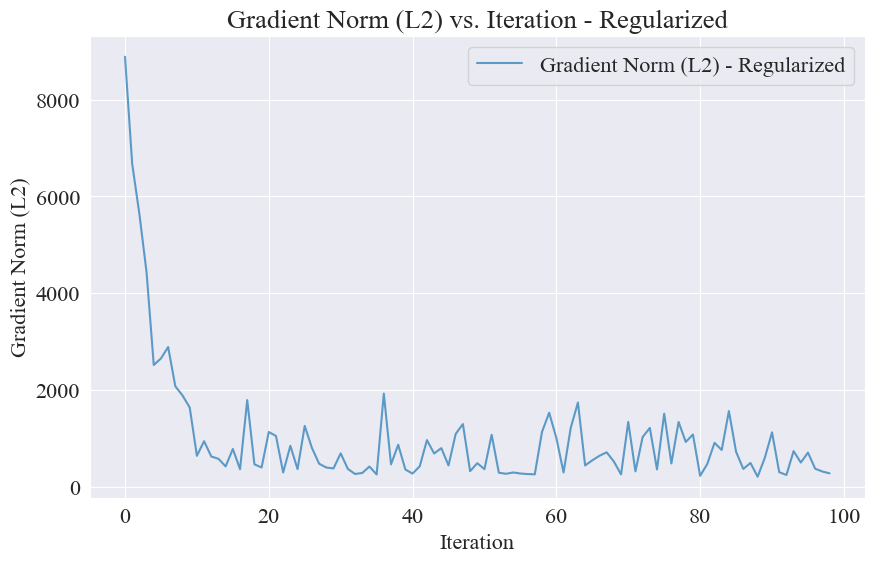

In [11]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Define the optimizer with L2 regularization
optimizer_re = SGD_regularization(learning_rate=1/1e+6, max_iters=100, record_history=True, batch_size=64, lambda_=0.01, type="L2")

# Create a Linear Regression model using SGD
model_LR_SGD_re = LinearRegression_SGD()

# Train the model on the training data
model_LR_SGD_re.fit(X_train, y_train, optimizer_re)

# Get a separate copy of the gradient history for plotting
grad_history_re = list(optimizer_re.grad_history)  # Make a copy

# Make predictions on the test data
prediction = model_LR_SGD_re.predict(X_test)

# Calculate the Mean Squared Error (MSE) for the predictions
mse_re = calculate_mse(y_test, prediction)

# Evaluate the model's performance using 5-fold Cross-Validation
average_mse_re = perform_5_fold_cross_validation(model_LR_SGD_re, X_train, y_train, optimizer_re)

# Print the calculated MSE and average Cross-Validation MSE
print(f"MSE = {mse_re:.4f}")
print(f"5-fold Cross-Validation Avg. MSE = {average_mse_re:.4f}")

# Plot the gradient changes over iterations for the L2 regularized model (limit to the first 500 iterations)
plt.figure(figsize=(10, 6))
plt.plot(range(len(grad_history_re)), [np.linalg.norm(grad, ord=2) for grad in grad_history_re], label='Gradient Norm (L2) - Regularized', alpha=0.7)

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm (L2)')
plt.title('Gradient Norm (L2) vs. Iteration - Regularized')
plt.legend()
plt.grid(True)
plt.show()


Fold 1: MSE = 137.50854816114477
Fold 2: MSE = 122.52289678724443
Fold 3: MSE = 224.9269368215963
Fold 4: MSE = 166.43337137567394
Fold 5: MSE = 133.1604697601964
Fold 1: MSE = 137.50907792333743
Fold 2: MSE = 122.52338467104987
Fold 3: MSE = 224.92785274336234
Fold 4: MSE = 166.4341135992979
Fold 5: MSE = 133.16106566750418
Fold 1: MSE = 137.50854400352463
Fold 2: MSE = 122.52289451422128
Fold 3: MSE = 224.92692315272978
Fold 4: MSE = 166.43336295178233
Fold 5: MSE = 133.16046535512197
MSE with L2 Regularization = 183.3108
5-fold Cross-Validation Avg. MSE with L2 Regularization = 156.9104
MSE with L1 Regularization = 183.0167
5-fold Cross-Validation Avg. MSE with L1 Regularization = 156.9111
MSE without Regularization = 182.9535
5-fold Cross-Validation Avg. MSE without Regularization = 156.9104


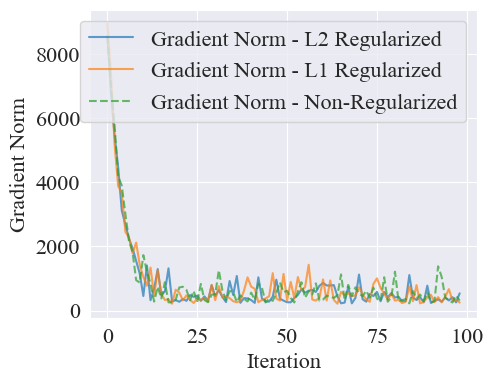

In [17]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Define the optimizer with L2 and L1 regularization
optimizer_re_L2 = SGD_regularization(learning_rate=1/1e+6, max_iters=100, record_history=True, batch_size=128, lambda_=0.01, type="L2")
optimizer_re_L1 = SGD_regularization(learning_rate=1/1e+6, max_iters=100, record_history=True, batch_size=128, lambda_=0.01, type="L1")
optimizer = SGD(learning_rate=1/1e+6, max_iters=100, record_history=True, batch_size=128)

# Create Linear Regression models using SGD and SGD with regularization
model_LR_SGD_re_L2 = LinearRegression_SGD()
model_LR_SGD_re_L1 = LinearRegression_SGD()
model_LR_SGD = LinearRegression_SGD()

# Train the models on the training data
model_LR_SGD_re_L2.fit(X_train, y_train, optimizer_re_L2)
model_LR_SGD_re_L1.fit(X_train, y_train, optimizer_re_L1)
model_LR_SGD.fit(X_train, y_train, optimizer)

# Get a separate copy of the gradient history for plotting
grad_history_re_L2 = list(optimizer_re_L2.grad_history)
grad_history_re_L1 = list(optimizer_re_L1.grad_history)
grad_history = list(optimizer.grad_history)

# Make predictions on the test data
prediction_re_L2 = model_LR_SGD_re_L2.predict(X_test)
prediction_re_L1 = model_LR_SGD_re_L1.predict(X_test)
prediction = model_LR_SGD.predict(X_test)

# Calculate the Mean Squared Error (MSE) for the predictions
mse_re_L2 = calculate_mse(y_test, prediction_re_L2)
mse_re_L1 = calculate_mse(y_test, prediction_re_L1)
mse = calculate_mse(y_test, prediction)

# Evaluate the models' performance using 5-fold Cross-Validation
average_mse_re_L2 = perform_5_fold_cross_validation(model_LR_SGD_re_L2, X_train, y_train, optimizer_re_L2)
average_mse_re_L1 = perform_5_fold_cross_validation(model_LR_SGD_re_L1, X_train, y_train, optimizer_re_L1)
average_mse = perform_5_fold_cross_validation(model_LR_SGD, X_train, y_train, optimizer)

# Print the calculated MSE and average Cross-Validation MSE
print(f"MSE with L2 Regularization = {mse_re_L2:.4f}")
print(f"5-fold Cross-Validation Avg. MSE with L2 Regularization = {average_mse_re_L2:.4f}")
print(f"MSE with L1 Regularization = {mse_re_L1:.4f}")
print(f"5-fold Cross-Validation Avg. MSE with L1 Regularization = {average_mse_re_L1:.4f}")
print(f"MSE without Regularization = {mse:.4f}")
print(f"5-fold Cross-Validation Avg. MSE without Regularization = {average_mse:.4f}")

# Plot the gradient changes over iterations for all models
plt.figure(figsize=(5, 4))
plt.plot(range(len(grad_history_re_L2)), [np.linalg.norm(grad, ord=2) for grad in grad_history_re_L2], label='Gradient Norm - L2 Regularized', alpha=0.7)
plt.plot(range(len(grad_history_re_L1)), [np.linalg.norm(grad, ord=2) for grad in grad_history_re_L1], label='Gradient Norm - L1 Regularized', alpha=0.7)
plt.plot(range(len(grad_history)), [np.linalg.norm(grad, ord=2) for grad in grad_history], label='Gradient Norm - Non-Regularized', alpha=0.7, linestyle='dashed')

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.legend()
plt.grid(True)
plt.show()


# Test the MSE with the numerical method

In [70]:
# Create a LinearRegression_numerical model
model_LR_numerical = LinearRegression_numerical(add_bias=True)

# Fit the model to the training data
model_LR_numerical.fit(X_train, y_train)

# Make predictions on the test data
prediction_numerical = model_LR_numerical.predict(X_test)

# Calculate the Mean Squared Error (MSE) for the predictions
mse_numerical = calculate_mse(y_test, prediction_numerical)

# Print the calculated MSE and average Cross-Validation MSE
print(f"MSE (Numerical) = {mse_numerical:.4f}")

MSE (Numerical) = 27.4182


# Test with data normalization

Fold 1: MSE = 133.35814762925574
Fold 2: MSE = 208.95921129351112
Fold 3: MSE = 116.8037593272402
Fold 4: MSE = 124.06090051170722
Fold 5: MSE = 133.11118615733653
MSE = 35.4375
5-fold Cross-Validation Avg. MSE = 143.2586


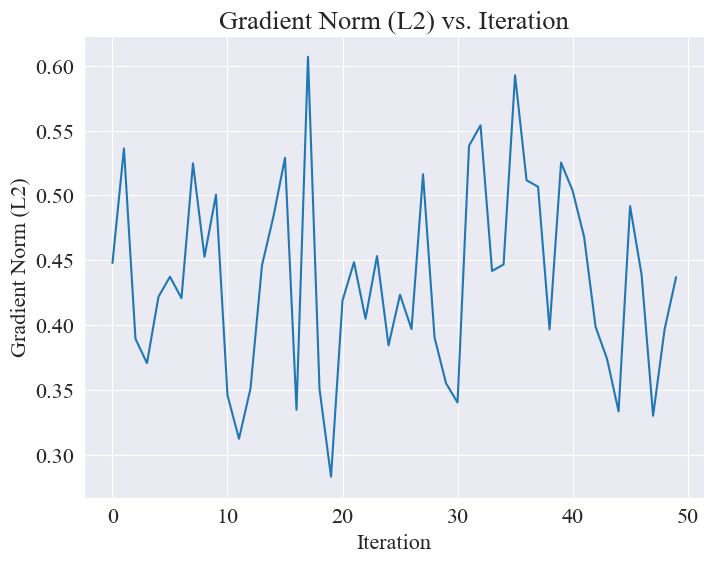

In [15]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

mean_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)

mean_test = np.mean(X_test, axis=0)
std_test = np.std(X_test, axis=0)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)


# 使用均值和标准差进行 Z-Score 标准化
normalized_X_train = (X_train - mean_train) / std_train
normalized_X_test = (X_test - mean_test) / std_test
normalized_X = (X - mean) / std

# Create an instance of your LinearRegression_SGD class
model_LR_SGD = LinearRegression_SGD()

optimizer = SGD(learning_rate=0.1, max_iters=50, record_history=True, batch_size=128)

# Lists to store gradient norms and intercepts over iterations
grad_norms = []
intercepts = []

for t in range(optimizer.max_iters):
    indices = np.random.choice(len(normalized_X_train), optimizer.batch_size, replace=False)
    x_batch = normalized_X_train[indices, :]
    y_batch = y_train[indices]
    
    # Train the model on the mini-batch
    model_LR_SGD.fit(x_batch, y_batch, optimizer)
    
    # Get the gradient from grad_history
    grad = optimizer.grad_history[-1]  # Get the gradient from the last iteration
    grad_norm = np.linalg.norm(grad, ord=2)
    grad_norms.append(grad_norm)

# Make predictions on the test data
prediction = model_LR_SGD.predict(normalized_X_test)

mse = calculate_mse(y_test, prediction)
average_mse = perform_5_fold_cross_validation(model_LR_SGD, normalized_X, y, optimizer)

print(f"MSE = {mse:.4f}")
print(f"5-fold Cross-Validation Avg. MSE = {average_mse:.4f}")

# Plot the gradient norms over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(optimizer.max_iters), grad_norms)
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm (L2)')
plt.title('Gradient Norm (L2) vs. Iteration')
plt.grid(True)
plt.show()


Fold 1: MSE = 133.35814762925574
Fold 2: MSE = 208.95921129351112
Fold 3: MSE = 116.8037593272402
Fold 4: MSE = 124.06090051170722
Fold 5: MSE = 133.11118615733653
MSE = 35.4375
5-fold Cross-Validation Avg. MSE = 143.2586


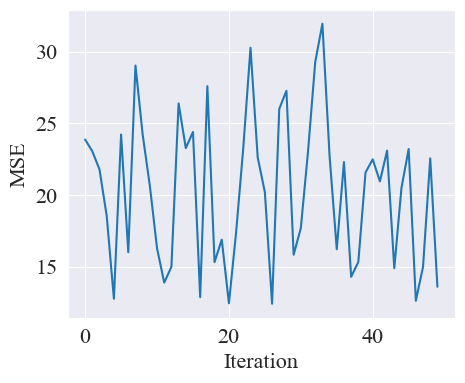

In [7]:

# Set a fixed random seed for reproducibility
np.random.seed(seed)

mean_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)

mean_test = np.mean(X_test, axis=0)
std_test = np.std(X_test, axis=0)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)


# 使用均值和标准差进行 Z-Score 标准化
normalized_X_train = (X_train - mean_train) / std_train
normalized_X_test = (X_test - mean_test) / std_test
normalized_X = (X - mean) / std

# Create an instance of your LinearRegression_SGD class
model_LR_SGD = LinearRegression_SGD()

optimizer = SGD(learning_rate=0.1, max_iters=50, record_history=True, batch_size=128)
# Assuming that optimizer has an attribute mse_history which stores the mse for each iteration

# Lists to store MSE values over iterations
mse_values = []

for t in range(optimizer.max_iters):
    indices = np.random.choice(len(normalized_X_train), optimizer.batch_size, replace=False)
    x_batch = normalized_X_train[indices, :]
    y_batch = y_train[indices]
    
    # Train the model on the mini-batch
    model_LR_SGD.fit(x_batch, y_batch, optimizer)
    
    # Get the mse from mse_history
    mse = optimizer.mse_history[-1]  # Get the mse from the last iteration
    mse_values.append(mse)

# Make predictions on the test data
prediction = model_LR_SGD.predict(normalized_X_test)

mse = calculate_mse(y_test, prediction)
average_mse = perform_5_fold_cross_validation(model_LR_SGD, normalized_X, y, optimizer)

print(f"MSE = {mse:.4f}")
print(f"5-fold Cross-Validation Avg. MSE = {average_mse:.4f}")

# Plot the MSE values over iterations
plt.figure(figsize=(5, 4))
plt.plot(range(optimizer.max_iters), mse_values)
plt.xlabel('Iteration')
plt.ylabel('MSE')
# plt.title('MSE vs. Iteration with data normalization')
plt.grid(True)
plt.show()


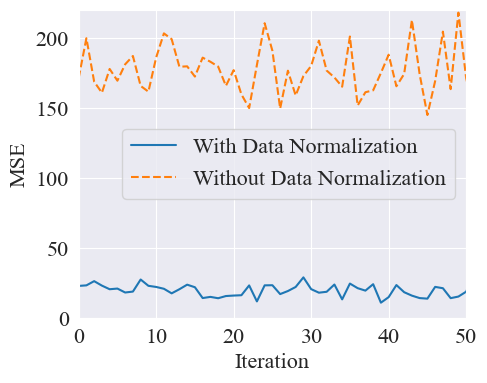

In [15]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

# Create an instance of your LinearRegression_SGD class
model_LR_SGD = LinearRegression_SGD()
optimizer = SGD(learning_rate=0.1, max_iters=500, record_history=True, batch_size=128)

# Lists to store MSE values over iterations
normalized_mse_values = []
non_normalized_mse_values = []

# Training with normalized data
for t in range(optimizer.max_iters):
    indices = np.random.choice(len(normalized_X_train), optimizer.batch_size, replace=False)
    x_batch = normalized_X_train[indices, :]
    y_batch = y_train[indices]
    
    # Train the model on the mini-batch
    model_LR_SGD.fit(x_batch, y_batch, optimizer)
    
    # Get the mse from mse_history
    mse = optimizer.mse_history[-1]  # Get the mse from the last iteration
    normalized_mse_values.append(mse)

# Reset the model and optimizer for training with non-normalized data
model_LR_SGD = LinearRegression_SGD()
optimizer = SGD(learning_rate=1e-6, max_iters=500, record_history=True, batch_size=128)

# Training with non-normalized data
for t in range(optimizer.max_iters):
    indices = np.random.choice(len(X_train), optimizer.batch_size, replace=False)
    x_batch = X_train[indices, :]
    y_batch = y_train[indices]
    
    # Train the model on the mini-batch
    model_LR_SGD.fit(x_batch, y_batch, optimizer)
    
    # Get the mse from mse_history
    mse = optimizer.mse_history[-1]  # Get the mse from the last iteration
    non_normalized_mse_values.append(mse)

# Plot the MSE values over iterations
plt.figure(figsize=(5, 4))
plt.plot(range(optimizer.max_iters), normalized_mse_values, label='With Data Normalization')
plt.plot(range(optimizer.max_iters), non_normalized_mse_values, label='Without Data Normalization', linestyle='dashed')
plt.xlabel('Iteration')
plt.ylabel('MSE')
# plt.title('MSE vs. Iteration with/without normalization')
plt.legend()
plt.grid(True)
plt.ylim(0,220)
plt.xlim(0,50)
plt.show()


# test with 5 gaussian basis

In [14]:
# Set a fixed random seed for reproducibility
np.random.seed(seed)

#///////////////////////////
# Choose the centers and variances of Gaussian basis functions
num_features = X.shape[1]
num_gaussians = 5

# Randomly initialize the centers of the Gaussian functions
centers = np.random.rand(num_features, num_gaussians)
# Set variances to 1 (you can adjust this based on domain knowledge)
variances = np.ones((num_features, num_gaussians))

# Generate Gaussian function values for the training data
gaussian_features_train = np.exp(-0.5 * ((X_train[:, :, np.newaxis] - centers) / variances) ** 2)

# Combine the values of Gaussian functions
gaussian_X_train = gaussian_features_train.reshape(X_train.shape[0], -1)

# Generate Gaussian function values for the test data
gaussian_features_test = np.exp(-0.5 * ((X_test[:, :, np.newaxis] - centers) / variances) ** 2)

# Combine the values of Gaussian functions
gaussian_X_test = gaussian_features_test.reshape(X_test.shape[0], -1)
#//////////////////////////

# Create instances of the LinearRegression_numerical class
model1 = LinearRegression_numerical()
model2 = LinearRegression_numerical()

# Fit the first model on the original features
model1.fit(X_train, y_train)

# Fit the second model on the Gaussian features
model2.fit(gaussian_X_train, y_train)


# Make predictions with both models
prediction1 = model1.predict(X_test)
prediction2 = model2.predict(gaussian_X_test)
prediction3 = model2.predict(gaussian_X_train)

# Calculate the Mean Squared Error (MSE) for both predictions
mse1 = calculate_mse(y_test, prediction1)
mse2 = calculate_mse(y_test, prediction2)
mse3 = calculate_mse(y_train, prediction3)

# Print the MSE values for both models
print("MSE without Gaussian basis functions:", mse1)
print("MSE with 5 Gaussian basis functions_test:", mse2)
print("MSE with 5 Gaussian basis functions_train:", mse3)

MSE without Gaussian basis functions: 27.418187087768285
MSE with 5 Gaussian basis functions_test: 75051.04487963395
MSE with 5 Gaussian basis functions_train: 150.66428566985687
